# Bird Species Classifier for AML project using Tensorflow
## University of Vienna, S2022
---
### Goal: An image recognition model
#### Open Questions:
* Which methods to use? 
* Which model to train?
* What is the class_dict.csv for?
* Do we need both valid set and test set?

In [1]:
import numpy as np
import pandas as pd

# To search directories
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

# Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers,mixed_precision

# Model Selection
from sklearn.metrics import confusion_matrix, classification_report

# Let's get started

### CSV data

In [2]:
birds_english = "../input/100-bird-species/birds.csv"
birds_latin = "../input/100-bird-species/birds latin names.csv"

In [3]:
birds_df = pd.read_csv(birds_english)
# clean column names
birds_df.columns = [col.replace(' ', '_').lower() for col in birds_df.columns]
birds_df.head()

,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [4]:
birds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62388 entries, 0 to 62387
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  62388 non-null  int64 
 1   filepaths    62388 non-null  object
 2   labels       62388 non-null  object
 3   data_set     62388 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [5]:
birds_df.value_counts("data_set").head()

data_set
train    58388
test      2000
valid     2000
dtype: int64

In [6]:
# Frequency of bird species in the whole dataset
print("|species | f|")
birds_df.value_counts("class_index")

|species | f|


class_index
224    259
144    243
287    243
363    227
396    224
      ... 
129    130
122    130
346    130
326    130
62     130
Length: 400, dtype: int64

In [7]:
# Look at csv entries for one single bird

#mask = birds_df['labels'].str.contains("ABBOTTS BABBLER") # Search for text fragment
#mask = birds_df.query('labels == "ABBOTTS BABBLER"') # query for name (case sensitive!)
mask = birds_df.loc[birds_df['class_index'] == 0]
print(mask.value_counts("data_set"))
mask

data_set
train    166
test       5
valid      5
dtype: int64


,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train
...,...,...,...,...
60388,0,valid/ABBOTTS BABBLER/1.jpg,ABBOTTS BABBLER,valid
60389,0,valid/ABBOTTS BABBLER/2.jpg,ABBOTTS BABBLER,valid
60390,0,valid/ABBOTTS BABBLER/3.jpg,ABBOTTS BABBLER,valid
60391,0,valid/ABBOTTS BABBLER/4.jpg,ABBOTTS BABBLER,valid


### Image data

In [8]:
# Filepaths
rootpath = "../input/100-bird-species"
trainpath = "../input/100-bird-species/train"
validpath = "../input/100-bird-species/valid"
testpath = "../input/100-bird-species/test"
pretest_path = "../input/100-bird-species/images to test"
paths = [pretest_path, trainpath, validpath, testpath]

In [9]:
"""def importImagesTest(path):
    images = []
    
    # Iterate over all files and subfolders
    for root, dirs, filenames in os.walk(path):
        print(root)
        print(dirs)
        print(filenames)
        print("-----------")
        # Iterate all filenames
        for file in filenames:
            # Store the filename for later inspection
            files.append(file)
            
    return pd.DataFrame(files)
            
test_images_df = importImagesTest(pretest_path)
test_images_df""";

In [10]:
'''def importAllImages(path):
    train = []
    valid = []
    test = []
    
    # Iterate over all files and subfolders
    for pathname, dirname, filenames in os.walk(path):
       # print(">>",pathname)
        #print(dirname)
        #print(filenames)
       # print("-----------")
            
        if "100-bird-species/valid" in pathname:
            print("validation data found - start filenames loop")
            print(filenames)
            for file in filenames:
                valid.append(img_to_array(file))
    """        elif pathname.endswith("/valid"):
            for file in filenames:
                valid.append(file)
        elif pathname.endswith("/test"):
            for file in filenames:
                test.append(file)
    """            
    return pd.DataFrame(train), pd.DataFrame(valid), pd.DataFrame(test)
            
#train_img_df, valid_img_df, test_img_df = importAllImages(rootpath)
#valid_img_df''';

### Plot random birds

In [11]:
def plot_random_bird(path):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    target_class = random.choice(os.listdir(path))
    target_folder = os.path.join(path,target_class)
    random_image = random.sample(os.listdir(target_folder),5)
 
    plt.figure(figsize=(16,5))
    for i in range(5):
        
        plt.subplot(1,5,i+1)
        img = tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img = tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}\n{img.shape}')
        plt.axis(False)

2022-05-28 19:01:38.563995: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


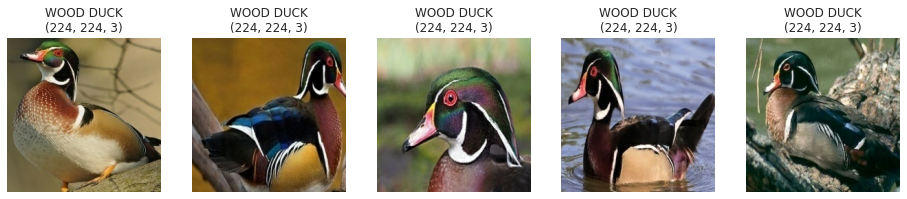

In [12]:
plot_random_bird(validpath)

In [13]:
'''def importFiles(path): 
    """
    Walk through and document the folder structure. Read images and foldernames into DataFrame. Return this DataFrame.
    """
    # Variable to store all files
    files = []

    # Iterate over all files and subfolders
    for dirname, _, filenames in os.walk(path):
        # Iterate all filenames
        for filename in filenames:
            # Store the filename for later inspection
            files.append(os.path.join(dirname, filename))

    print({len(files)}, "files are in the directories.")

    # Split the filenames into subfolders and filename
    # Remove the first three folders (home, kaggle and input) since they do not add new information
    files_split = [file.split('/')[3:] for file in files]

    # Store the split files as DataFrame to get aggregated summaries 
    df = pd.DataFrame(files_split)

    return df

folder_df = importFiles(testpath)
print('\nThese are some sampled entries:')
folder_df.sample(3)''';

# Prepare data for model

### Generate tf.data.Dataset objects from image files in directories

In [14]:
"""
GPUs and TPUs can radically reduce the time required to execute a single training step. 
Achieving peak performance requires an efficient input pipeline that delivers data for 
the next step before the current step has finished. The tf.data API helps to build flexible 
and efficient input pipelines.
~ https://www.tensorflow.org/guide/data_performance
"""
IMAGE_SIZE=(224,224) # constant value

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    trainpath,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
class_names = train_data.class_names
num_classes = len(class_names)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    validpath,
    label_mode='categorical',
    image_size=IMAGE_SIZE,    
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    testpath,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)
#---------------------------------------------------------------#
"""
The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used 
to decouple the time when data is produced from the time when data is consumed. In particular, 
the transformation uses a background thread and an internal buffer to prefetch elements from 
the input dataset ahead of the time they are requested. The number of elements to prefetch 
should be equal to (or possibly greater than) the number of batches consumed by a single training step. 
You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the 
tf.data runtime to tune the value dynamically at runtime.
~ https://www.tensorflow.org/guide/data_performance
"""

train_data_pf = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_pf = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_pf = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 58388 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


#### Define train, validation and test data X and y

In [15]:
X_train = birds_df.loc[birds_df['data_set']=="train"].drop("class_index", axis=1).copy()
y_train = birds_df.loc[birds_df['data_set']=="train"]["class_index"].copy()

X_valid = birds_df.loc[birds_df['data_set']=="valid"].drop("class_index", axis=1).copy()
y_valid = birds_df.loc[birds_df['data_set']=="valid"]["class_index"].copy()

X_test = birds_df.loc[birds_df['data_set']=="test"].drop("class_index", axis=1).copy()
y_test = birds_df.loc[birds_df['data_set']=="test"]["class_index"].copy()

In [16]:
y_train

0          0
1          0
2          0
3          0
4          0
        ... 
58383    399
58384    399
58385    399
58386    399
58387    399
Name: class_index, Length: 58388, dtype: int64

# README
after the first meeting

### Aufteilung
- keras tensorflow - Clemens
- pytorch - Jakob
- PCA + preprocessing - Lena 


### Methoden 
- pca?
- image segementation
- Wie laden wir die Bilder von der CSV ins Notebook?
- Wieviele Datenreihen brauchen wir? 
data set
| train    58388 | test      2000 | valid     2000 |
